# Visualizations of EEG signals

This Jupyter Notebook shows examples of EEG data vizualizations using the MNE Python library.

In [3]:
# Install the MNE package
!pip install mne

     |████████████████████████████████| 7.0MB 12.9MB/s 


**Imports**

In [4]:
# Essential libraries used for loading the dataset
import mne
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
import numpy as np

The function below perfoms all necessary data loading and preprocessing steps for using the EEG data with the MNE library

In [9]:
#Get epochs with sliding window 
def getEpochs(subjects, runs, event_id):
    # set your path to save the dataset
    dataset_path = './EEGBCI_dataset'
    tmin, tmax = -1., 4. 
    subject_row = []

    for subject in subjects:
        raw_fnames = eegbci.load_data(subject, runs, dataset_path)
        #concatenate multiply runs into one instance
        subject_row.append(concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames]))
    raw = concatenate_raws([row for row in subject_row])

    eegbci.standardize(raw)
    # set channel names standard_1005
    montage = make_standard_montage('standard_1005') # Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
    raw.set_montage(montage)

    # Strip channel names of "." characters
    raw.rename_channels(lambda x: x.strip('.'))

    # Apply band-pass filter 
    raw.filter(7., 30., fir_design='firwin', skip_by_annotation='edge')  # band pass filter 
    
    # Get events from raw signal 
    events, _ = events_from_annotations(raw, event_id=event_id)

    # Choose only EEG signals 
    picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False,
                    exclude='bads')

    # Get epochs from raw data
    # Epochs objects are a data structure for representing and analyzing 
    # equal-duration chunks of the EEG/MEG signal.
    epochs = Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=None, preload=True)

    epochs_data = epochs.get_data()
    labels = epochs.events[:, -1] - 1
        
    return epochs_data, labels, epochs, raw, events

## Load the data

In [10]:
%%capture 
#Load task 3 data 
#The data will automatically start download if you don't have it in the path you set 
# Note: It might take a while to download the data
#Choose subjects id from 1 to 20 
subjects = [i for i in range(1, 21)]

#Choose all task 3 runs 
task3_runs = [5, 9, 13]

#Set task event id
task3_event_id = dict(T1=1, T2=2) #T1 open fists, T2 open feet

#Get all task3 epoch data and its corresponding labels 
task3_epochs_data, task3_labels, epochs, raw, events = getEpochs(subjects, task3_runs, task3_event_id)

In [11]:
#Let's take a look at the data
print(task3_epochs_data.shape)
print(task3_labels.shape)

(888, 64, 801)
(888,)


# Visualizations



The `raw` object contains the full dataset.

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


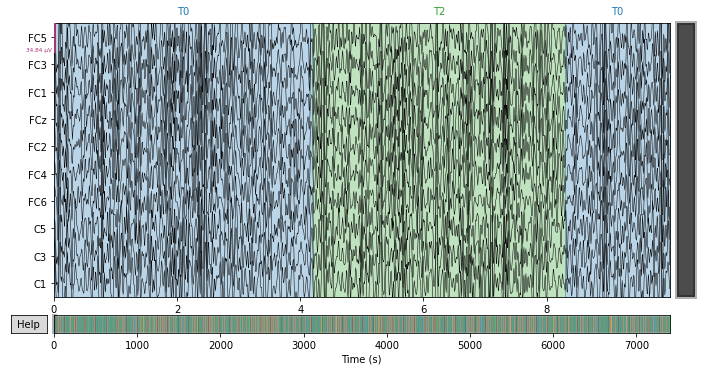

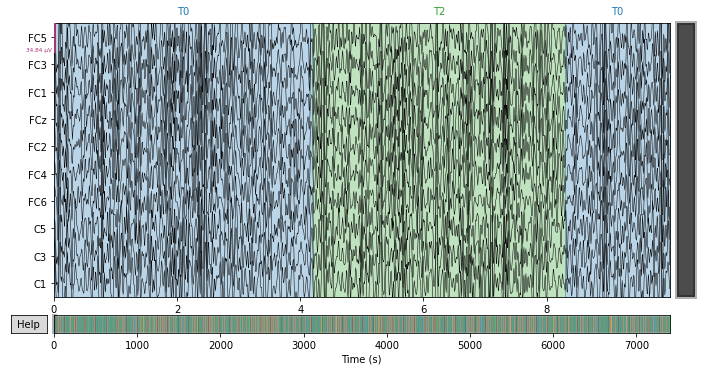

In [12]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (10,5)
# #plot channels by sets of 11
raw.plot(order=[x for x in range (0, 10)], scalings='auto', n_channels=10)

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


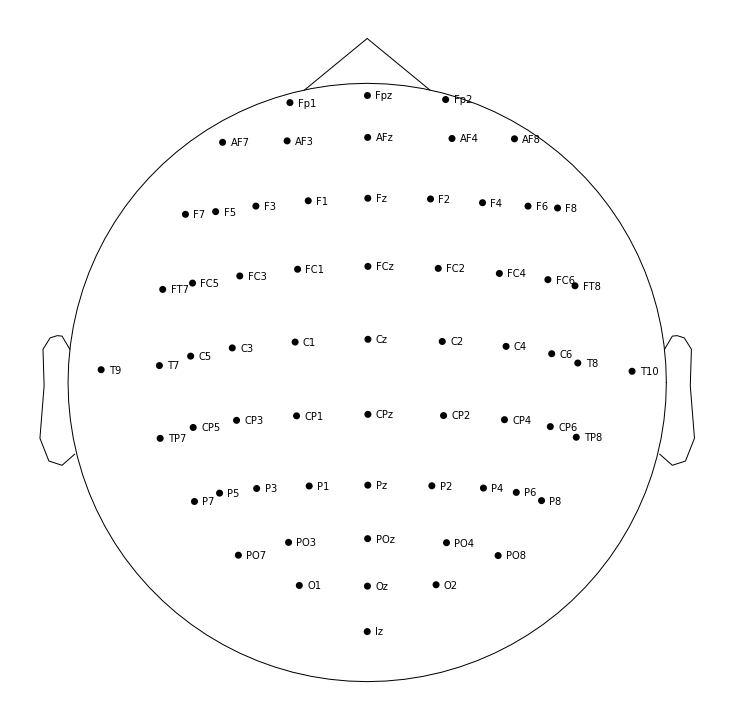

In [34]:
montage = raw.get_montage()
fig = montage.plot()

Let's show the time moments when the first 10 events occur.

Creating RawArray with float64 data, n_channels=64, n_times=1
    Range : 0 ... 0 =      0.000 ...     0.000 secs
Ready.


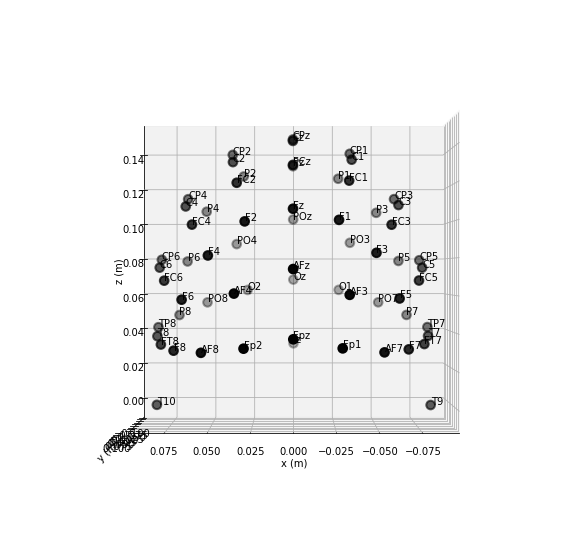

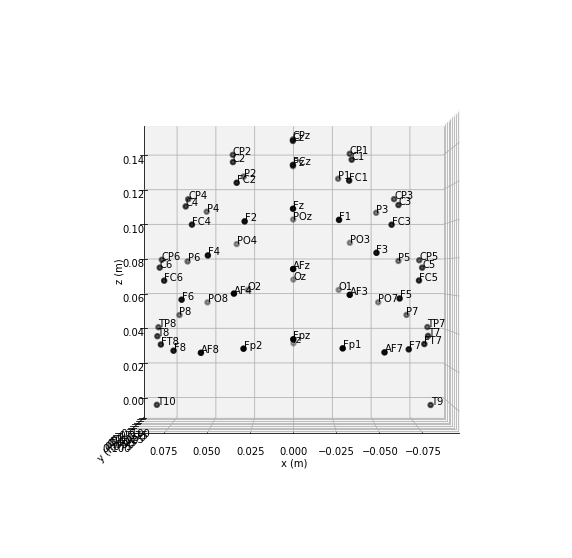

In [35]:
montage.plot(kind='3d')

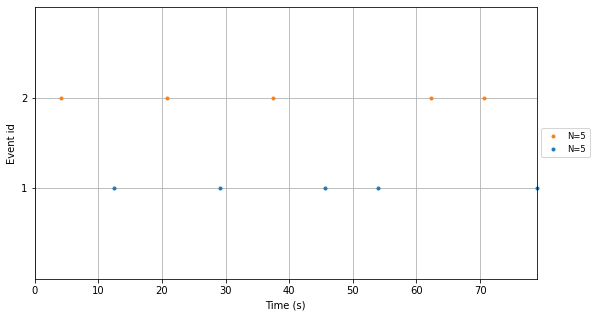

In [13]:
 mne.viz.plot_events(events[:10], sfreq=raw.info['sfreq']); # Print events observed in the first 50 epochs

We can visualize the raw *data* within one or more epochs. The figure below shows the raw EEG signals from 10 channels, the epoch number (under the graph) and the moments when the events occur (at the top of the graph)

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


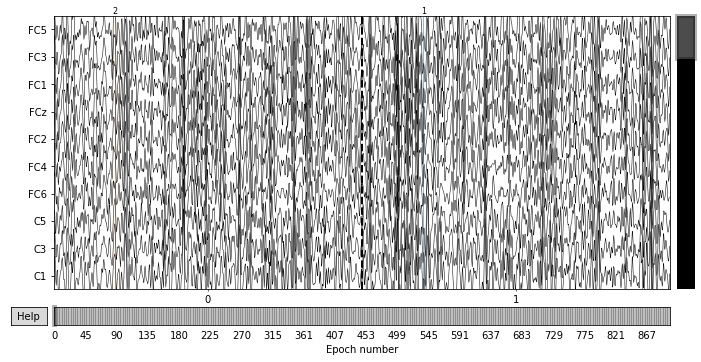

In [14]:
fig = epochs.plot(n_epochs=2, events=events, n_channels=10);

If you wish to look at the average across trial types, then you may do so, creating an Evoked object in the process. Instances of Evoked are usually created by calling mne.Epochs.average.

Visualizing the averages of different events can help humans see possible patterns that differ between events.

Not setting metadata
Not setting metadata
445 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Not setting metadata
Not setting metadata
455 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


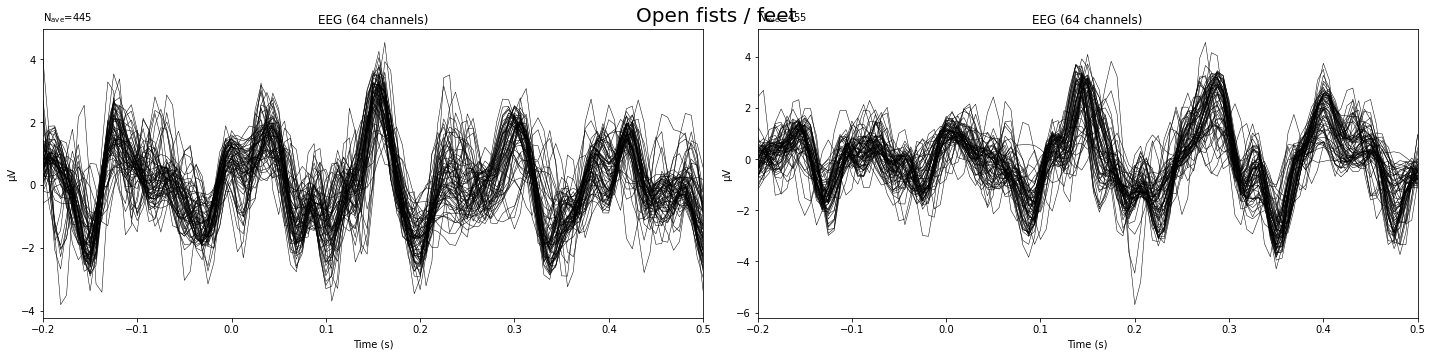

In [15]:
fist_avg_epochs = Epochs(raw, events, event_id=1).average()
feet_avg_epochs = Epochs(raw, events, event_id=2).average()

f, axs = plt.subplots(1, 2, figsize=(20, 5))
_ = f.suptitle('Open fists / feet', fontsize=20)
_ = fist_avg_epochs.plot(axes=axs[0], show=False, time_unit='s')
_ = feet_avg_epochs.plot(axes=axs[1], show=False, time_unit='s')
plt.tight_layout()

It’s also possible to plot epochs as an image

Not setting metadata
Not setting metadata
888 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


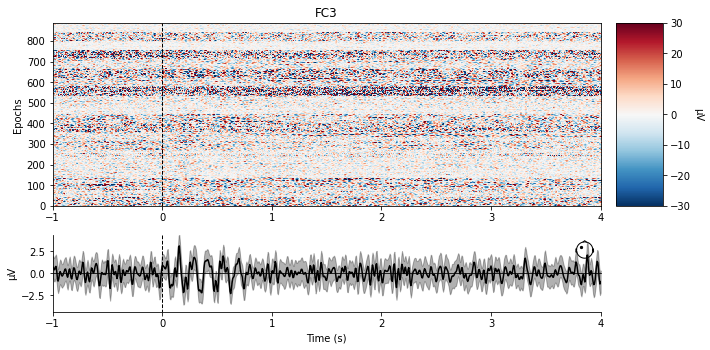

In [21]:
epochs.plot_image(1, cmap='interactive', sigma=1., vmin=-30, vmax=30);

**Plot Signal Traces with GFP**

The measure of global field power (GFP) corresponds to the spatial standard deviation, and it quantifies the amount of activity at each time point in the field considering the data from all recording electrodes simultaneously resulting in a reference-independent descriptor of the potential field. 

Global field power is plotted as a function of time, and the occurrence times of GFP maxima are used to determine the latencies of evoked potential components.

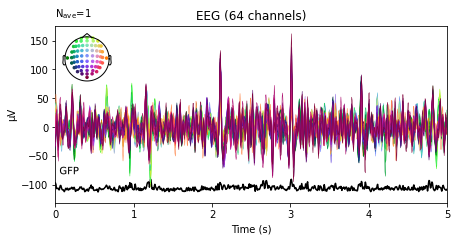

In [ ]:
evk = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
fig = evk.plot(picks='eeg', spatial_colors=True, gfp=True, window_title='EEG Channels')

**Compare Evoked Potentials**

combining channels using "gfp"
combining channels using "gfp"


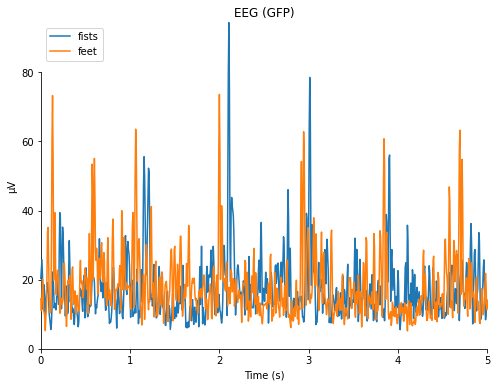

In [ ]:
evks = {}
evks['fists'] = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
evks['feet'] = mne.EvokedArray(epochs.get_data(item=1)[0,:,:], info=raw.info)
fig = mne.viz.plot_compare_evokeds(evks, picks='eeg')

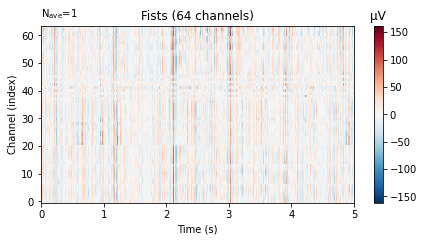

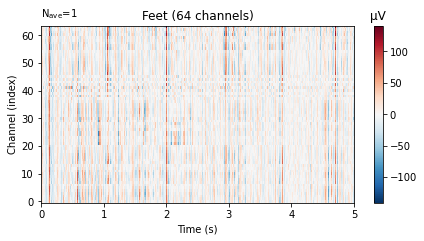

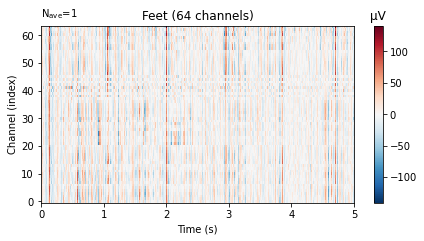

In [27]:
fists_evk = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
feet_evk = mne.EvokedArray(epochs.get_data(item=1)[0,:,:], info=raw.info)
fists_evk.plot_image(picks='eeg', titles=('Fists'))
feet_evk.plot_image(picks='eeg', titles=('Feet'))

**Topographical subplots**

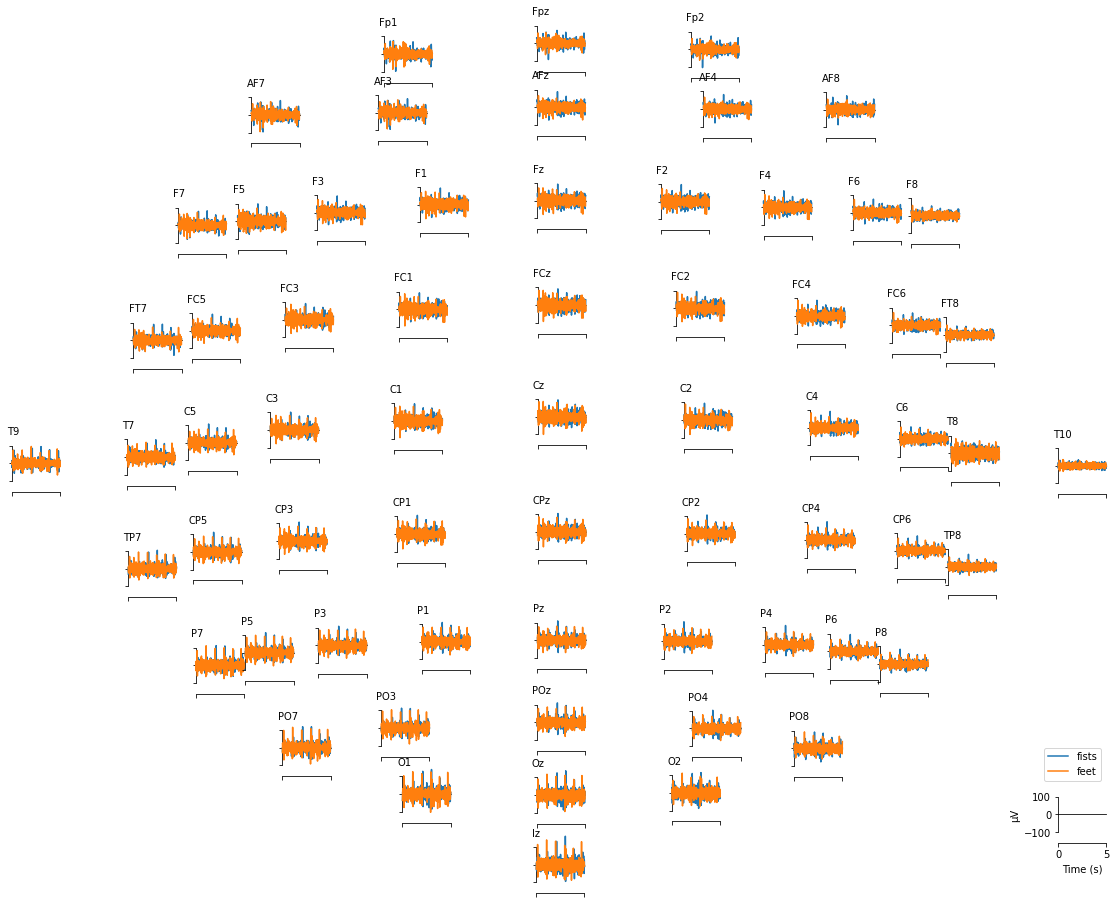

In [33]:
evks = {}
evks['fists'] = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
evks['feet'] = mne.EvokedArray(epochs.get_data(item=1)[0,:,:], info=raw.info)
fig = mne.viz.plot_compare_evokeds(evks, picks='eeg', axes='topo')
fig[0].savefig('evoked_array.pdf')

**Plot Sensor Positions**

**Scalp Topography**

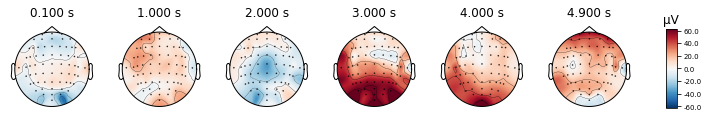

In [ ]:
#times to plot
times = [0.1, 1.0, 2.0, 3.0, 4.0, 4.9]
fists_evk = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
fig = evk.plot_topomap(ch_type='eeg', times=times, colorbar=True)

**Joint Plot**

No projector specified for this dataset. Please consider the method self.add_proj.


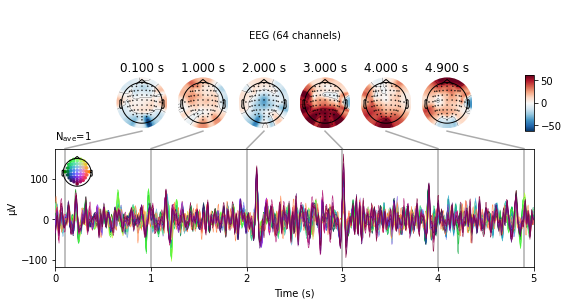

In [ ]:
#times to plot
times = [0.1, 1.0, 2.0, 3.0, 4.0, 4.9]
fists_evk = mne.EvokedArray(epochs.get_data(item=0)[0,:,:], info=raw.info)
fig = evk.plot_joint(times=times)